<img src="http://drive.google.com/uc?id=1o51pGoz29QwmTx4NhqDNyAf-a2zdXjjJ">

---

This notebook aims to demonstrate how we can access and analyze publically available DAS data. In this example, we will look at a vertical DAS (and colocated geophone) dataset from the monitoring well at the US Department of Energy's Enhanced Geothermal System FORGE Project in Utah. After checking out the data, we will analyze the passive seismic background noise levels and examine an earthquake wavefield.

##### Authors: 
* [Nate Lindsey](https://www.njlindsey.com)
<a href="https://colab.research.google.com/github/eileenrmartin/IntroToDASData/blob/master/Forge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



---

# Background

### The FORGE Project
The Frontier Observatory for Research in Geothermal Energy (FORGE) project funded by the US Department of Energy and hosted by the University of Utah is creating an underground laboratory for developing and testing innovative tools and stimulation techniques for developing enhanced geothermal system (EGS) reservoirs. The R&D focus is on strengthening understanding of the key mechanisms controlling EGS success, specifically how to initiate and sustain fracture networks in basement rock formations through innovative drilling techniques, reservoir stimulation techniques, well connectivity and flow-testing efforts, and novel continuous geophysical monitoring methodologies.

#####  Learn more about FORGE:
- [Univ. Utah FORGE site](https://utahforge.com/)
- [DOE FORGE site](https://www.energy.gov/eere/forge/forge-home)
- [Phase 2C Report from GDR](https://constantine.seis.utah.edu/datasets.html)

### Public Archive of FORGE (Phase-II) Data
As of July 2020, the FORGE (Phase-II) data are publically available in the archive [here](https://constantine.seis.utah.edu/datasets.html). This site provides access to the seismic data generated by the FORGE project. The data distribution is made possible by the University of Utah's Center for High Performance Computing (CHPC). Near the FORGE project's completion, the waveform data collected here is planned to be transferred to the Incorporated Research Institutions for Seismology Data Management Center (IRIS DMC).

##### The FORGE data include:
- Continuous Silixa iDAS Carina DAS data for 1280 channels from April - May 2019 [[Link to DAS Download Script]](https://constantine.seis.utah.edu/files/get_all_silixa.sh). 
- Continuous Schlumberger three-component geophone data from a 12-station array. [[Link to Geophone Download Script]](https://constantine.seis.utah.edu/files/get_all_slb.sh)
- $\underline{Note}$: There are a few “gaps” early in the DAS data, and acquisition parameters changed along the way. Recommended to use data after April 22nd.
- For the 2020 DAS Workshop and Tutorial, please use the pre-downloaded DAS and geophone data to avoid overloading the Utah servers.

### Setup environment
Many of the Python packages we'll use are already available in Colab. We are going to use [Obspy](https://docs.obspy.org/) throughout, so we first need to install this package via pip. We also need to download a few auxiliary files from the web using wget commands. The FORGE DAS data are accessible through the Utah sites (links above). There is also a Python library with some modules available via Google Drive that we have made available for this workshop. To run a bash (command-line) command like wget in a Jupyter notebook on Colab, use an ! before the command. 



In [1]:
#You only need to run this once, the first time you use the Google Colab
import scipy
#get obspy
!pip -q install obspy gdown
#some das utilities
!gdown -q https://drive.google.com/uc?id=1aBEF07MSaCCHSmkHQ4ibq3hZI42lEnVL  -O forgeUtils.py
#pre-downloaded FORGE Data
!gdown -q https://drive.google.com/uc?id=190ljQs25UyBdnRTGfvkPI7Ovfm11J05T -O forgeData.zip 
!unzip -o -q forgeData.zip
!rm -r __MACOSX
!rm -r forgeData.zip
#Univ. of Utah scripts to download more FORGE Data, please do not use during the Workshop.
!gdown -q https://drive.google.com/uc?id=1SZCKJwod3APDAIlxLAe6RkqXFAC6z3EW -O get_all_silixa.sh
!gdown -q https://drive.google.com/uc?id=1oHF3unxARvFh31q-EhLDRyr02ngVdC5N -O get_all_slb.sh

In [2]:
#Run this every time you restart

%matplotlib inline
import os
import matplotlib.pyplot as plt
import numpy as np
import obspy
import forgeUtils as utils

# 0. Check out how easy this can be...

Reading forgeData/FORGE_78-32_iDASv3-P11_UTC190424222424.sgy
Reading forgeData/20190424222422.196.segy


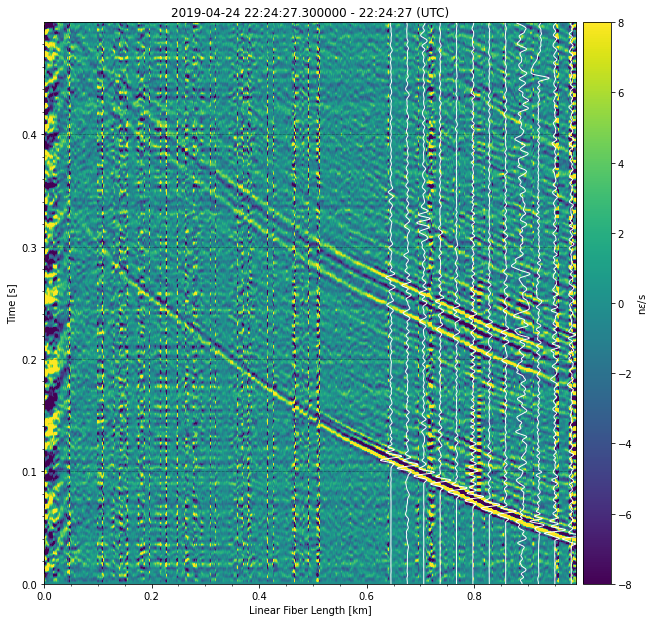

In [32]:
def easy(): 
    
    #setup
    import obspy
    import matplotlib.pyplot as plt
    import forgeUtils as utils

    #parameters
    gaugelength     = 10.0 
    dx_in_m         = 1.02
    das_units       = 'n$\epsilon$/s'
    geophone_units  = 'm/s^2'
    geophone_fac    = 2.333e-7
    fo_start_ch     = 197
    start = obspy.UTCDateTime(2019,4,24,22,24,27.3) # perforation #1 for demonstration
    end   = obspy.UTCDateTime(2019,4,24,22,24,27.8)

    #download
    files_das = utils.download(utils.get_paths('das',[start,end]), switch='workshop')
    files_geo = utils.download(utils.get_paths('geophone',[start,end]), switch='workshop')
        
    #read
    das   = utils.read(files_das,dx_in_m=dx_in_m,timerange=[start,end],units=das_units,fo_start_ch=fo_start_ch)
    geo   = utils.read(files_geo,timerange=[start,end],fac=geophone_fac,units=geophone_units)
        
    #process
    das = utils.medianSubtract(das)
    das.filter('bandpass',freqmin=10,freqmax=150)
    geo.filter('bandpass',freqmin=10,freqmax=150)
    
    #plot
    fig = utils.image(das,style=1,skip=1,physicalFiberLocations=True,clim=[-8,8])
    fig = utils.wiggle(geo.select(channel='Z'),color='w',skip=1,style=1,scale=1.,fig=fig)
    plt.xlim([0.,.99]);

#
easy()

This half second of DAS recording shows the full fiber length plotted for the first perforation shot on April 24, 2019. Geophones are plotted on top as white traces. The P-wave arrives at the bottom of the well and propagates up the well, followed by a second P-wave ~0.15 s later.

# 1. Download FORGE Data

### How do I automatically download DAS files from FORGE (Phase-II) archive?

Set the time range of interest for the event or continuous time period. We can build up a catalog dictionary of events when we know there will be some action. To find more events you could look through the FORGE Report, or use a tool like [IRIS Wilber3](www.wilber3.com) to find some earthquakes. 

In [4]:
# Catalog
events = {'0':{'eventName':'perf1','eventTime':obspy.UTCDateTime(2019,4,24,22,24,27.3)},
          '1':{'eventName':'perf2','eventTime':obspy.UTCDateTime(2019,4,29,16,50,0)}}

# Event example
duration = 1; # seconds
start = events['0']['eventTime']
end   = start+duration

# Continuous example
# start = obspy.UTCDateTime(2019,5,2,0,12,0)
# end = obspy.UTCDateTime(2019,5,2,0,13,5)

Convert time range to the unique download urls for either 'das' or 'geophone' using the $\textbf{get_paths}$ method. Then request each file url using wget in batch mode using the $\textbf{download}$ method. The data will be downloaded to a $\textbf{forgeData}$ directory.

In [5]:
urls = utils.get_paths('das',[start,end])
urls

['wget -q https://pando-rgw01.chpc.utah.edu/silixa_das_apr_24_2019/FORGE_78-32_iDASv3-P11_UTC190424222424.sgy']

In [6]:
files_das = utils.download(urls,switch='workshop')
files_das

['forgeData/FORGE_78-32_iDASv3-P11_UTC190424222424.sgy']

Repeat for geophone data, so we have it for later comparisons. The geophone data will be downloaded to the same new directory called $\textbf{forgeData}$, but we can tell these apart by their different suffixes.

In [7]:
urls2 = utils.get_paths('geophone',[start,end])
urls2

['wget -q https://pando-rgw01.chpc.utah.edu/slb_2019_MW78-32_010/20190424222422.196.segy']

In [8]:
files_geo = utils.download(urls2,switch='workshop')
files_geo

['forgeData/20190424222422.196.segy']

There are presently many DAS data formats including SEG-Y, Mini-SEED, TDMS, HDF-5, and PRODML. The array datatype, size of individual files, and desire to be able to slice sections of the array in space and time are driving the community to adopt heirarchical dataformats (HDF-5, PRODML). However, the standard is yet to be set (as of July 2020). The FORGE Project (Phase-II) recorded SEG-Y data files. SEG-Y files are organized Streams of seismic waveform Traces with individual trace headers describing channel parameters. This is similar to Mini-SEED.

# 2. QA/QC the Data

### How do I check that the data I downloaded are OK?

Using Obspy, try reading in the first SEG-Y file downloaded above, and examine the stream and a trace header (stats).

$\textit{Note: the normal obspy read function will not work, so use obspy.io.segy.core._read_segy() instead}$

In [9]:
import obspy.io.segy.core
das = obspy.io.segy.core._read_segy(files_das[0],format='segy',unpack_trace_headers=True)
print(das[:15].__str__(extended=True))

15 Trace(s) in Stream:
Seq. No. in line:    1 | 2019-04-24T22:24:24.000000Z - 2019-04-24T22:24:38.999500Z | 2000.0 Hz, 30000 samples
Seq. No. in line:    2 | 2019-04-24T22:24:24.000000Z - 2019-04-24T22:24:38.999500Z | 2000.0 Hz, 30000 samples
Seq. No. in line:    3 | 2019-04-24T22:24:24.000000Z - 2019-04-24T22:24:38.999500Z | 2000.0 Hz, 30000 samples
Seq. No. in line:    4 | 2019-04-24T22:24:24.000000Z - 2019-04-24T22:24:38.999500Z | 2000.0 Hz, 30000 samples
Seq. No. in line:    5 | 2019-04-24T22:24:24.000000Z - 2019-04-24T22:24:38.999500Z | 2000.0 Hz, 30000 samples
Seq. No. in line:    6 | 2019-04-24T22:24:24.000000Z - 2019-04-24T22:24:38.999500Z | 2000.0 Hz, 30000 samples
Seq. No. in line:    7 | 2019-04-24T22:24:24.000000Z - 2019-04-24T22:24:38.999500Z | 2000.0 Hz, 30000 samples
Seq. No. in line:    8 | 2019-04-24T22:24:24.000000Z - 2019-04-24T22:24:38.999500Z | 2000.0 Hz, 30000 samples
Seq. No. in line:    9 | 2019-04-24T22:24:24.000000Z - 2019-04-24T22:24:38.999500Z | 2000.0 Hz, 3

In [10]:
print(das[15].stats)

         network: 
         station: 
        location: 
         channel: 
       starttime: 2019-04-24T22:24:24.000000Z
         endtime: 2019-04-24T22:24:38.999500Z
   sampling_rate: 2000.0
           delta: 0.0005
            npts: 30000
           calib: 1.0
            segy: AttribDict({'trace_header': AttribDict({'endian': '>', 'unpacked_header': None, 'trace_sequence_number_within_line': 16, 'trace_sequence_number_within_segy_file': 0, 'original_field_record_number': 22337, 'trace_number_within_the_original_field_record': 16, 'energy_source_point_number': 0, 'ensemble_number': 0, 'trace_number_within_the_ensemble': 16, 'trace_identification_code': 0, 'number_of_vertically_summed_traces_yielding_this_trace': 1, 'number_of_horizontally_stacked_traces_yielding_this_trace': 1, 'data_use': 0, 'distance_from_center_of_the_source_point_to_the_center_of_the_receiver_group': 0, 'receiver_group_elevation': 0, 'surface_elevation_at_source': 0, 'source_depth_below_surface': 0, 'datum_eleva

We need to find out some additional information about this experiment before we can proceed:
- The Phase 2C Report  states that the DAS data were recorded with a Silixa iDAS interrogator which used a $\textbf{10-m gauge length}$ with a  $\textbf{1.02 m channel spacing}$ (Section 2.2, p.5, B.III). 
- The data are provided in $\textbf{nanostrain/second}$ (nm/m/s) (Section 3.4, p.12). This is not what is natively recorded by the Silixa iDAS (optical phase / timesample). There is a scalar conversion from optical phase per timesample to nanostrain per second, and the report is effectively saying that this scalar multiplication has already been applied. The analogy here is how a seismometer records a voltage in V, but the instrument manufacturer may deliver data in m/s, having already applied the scalar V/m/s conversion factor.
- Geometry: The geometry of DAS arrays are usually challenging at first. The first channel is probably located inside the IU, not at the IU/cable connection point. "Tap testing" is a good way to establish $\textbf{"Key Locations"}$. It is also a good practice to only trust linear fiber lengths between key locations. At FORGE, the key locations would be the wellhead and the channel that corresponds to the instrument/cable connection point. Additionally, it is possible to record DAS data beyond the physical cable's far end. Channels before and after the physical cable length should be masked in preprocessing. In Silixa's Survey Report (Figure 3, p.9), a tap test is described and the following fiber map is delivered:
<img src="https://drive.google.com/uc?id=1muAsnQIurYLtxT1HnLx6zSKyRVek9n0d" width=600px> <img src="https://drive.google.com/uc?id=1r1rksUisMZcWhvOlVwSg9aTUQ08uqHo6" width=500px>

- From this information, we can gather that the linear fiber length between the two key points is 996.51 m (1037.8 m - 41.29m), which is equivalent to $\textbf{977 channels}$ (996.51 m/1.02m/channel). The wellhead's key location is not noted, but we can use this relative distance to find it later.

In [11]:
gaugelength = 10.0 #m
das_units = 'n$\epsilon$/s'
dx_in_m = 1.02 #m/channel
fo_distance_in_well = 996.51 #m

For the geophone data, we are told on the Utah data access webpage: "The following is downhole geophone data collected by Schlumberger....the units are bits. To convert to acceleration ($m/s^2$) multiply by $2.333 x 10^{-7}$."

In [12]:
geophone_fac = 2.333e-7
geophone_units = 'm/s^2'

With this info, we can populate trace headers.

In [13]:
das = utils.populate_das_segy_trace_headers(das,dx_in_m=dx_in_m)

Examine the first Trace again, to verify that the channel and location info are correct. Note that these pieces of info are hard-coded for this experiment in the utils.py file. The "station" is the 5-digit Trace index in the Stream, while the "location" is the position along the fiber in meters. The "channel" is a string that could be providing an orientation of the single component in the horizontal direction, or in this case is "Z" for vertical. In order to plot the "section" plot in the next section the "distance" info needs to be populated. 

In [14]:
print(das[15].stats)

         network: FORGE
         station: 00015
        location: 0
         channel: Z
       starttime: 2019-04-24T22:24:24.000000Z
         endtime: 2019-04-24T22:24:38.999500Z
   sampling_rate: 2000.0
           delta: 0.0005
            npts: 30000
           calib: 1.0
        distance: 15.3
            segy: AttribDict({'trace_header': AttribDict({'endian': '>', 'unpacked_header': None, 'trace_sequence_number_within_line': 16, 'trace_sequence_number_within_segy_file': 0, 'original_field_record_number': 22337, 'trace_number_within_the_original_field_record': 16, 'energy_source_point_number': 0, 'ensemble_number': 0, 'trace_number_within_the_ensemble': 16, 'trace_identification_code': 0, 'number_of_vertically_summed_traces_yielding_this_trace': 1, 'number_of_horizontally_stacked_traces_yielding_this_trace': 1, 'data_use': 0, 'distance_from_center_of_the_source_point_to_the_center_of_the_receiver_group': 0, 'receiver_group_elevation': 0, 'surface_elevation_at_source': 0, 'source_de

The $\textbf{read}$ method is available in the forgeUtils module to perform Trace header population, merging, and trimming on any list of das or geophone files.

In [15]:
das = utils.read(files_das,dx_in_m=dx_in_m,timerange=[start,end],units=das_units)

# Note: If you do not add in the timerange param you will load the full timerange downloaded. 
#  You can also change the timerange at this point to only read in part of the downloaded data.

Reading forgeData/FORGE_78-32_iDASv3-P11_UTC190424222424.sgy


In [16]:
das[10].stats

         network: FORGE
         station: 00010
        location: 0
         channel: Z
       starttime: 2019-04-24T22:24:27.300000Z
         endtime: 2019-04-24T22:24:28.300000Z
   sampling_rate: 2000.0
           delta: 0.0005
            npts: 2001
           calib: 1.0
        distance: 10.2
      processing: ['ObsPy 1.2.2: trim(endtime=UTCDateTime(2019, 4, 24, 22, 24, 28, 300000)::fill_value=None::nearest_sample=True::pad=False::starttime=UTCDateTime(2019, 4, 24, 22, 24, 27, 300000))']
            segy: AttribDict({'trace_header': AttribDict({'endian': '>', 'unpacked_header': None, 'trace_sequence_number_within_line': 11, 'trace_sequence_number_within_segy_file': 0, 'original_field_record_number': 22337, 'trace_number_within_the_original_field_record': 11, 'energy_source_point_number': 0, 'ensemble_number': 0, 'trace_number_within_the_ensemble': 11, 'trace_identification_code': 0, 'number_of_vertically_summed_traces_yielding_this_trace': 1, 'number_of_horizontally_stacked_traces_

...It also works for geophone files.

In [17]:
geo = utils.read(files_geo,timerange=[start,end],fac=geophone_fac,units=geophone_units)

Reading forgeData/20190424222422.196.segy


### Quick Restart

Here is a simple process containing everything needed to $\textbf{setup}$ for FORGE from scratch.

In [18]:
def setup(start,end):    
    gaugelength     = 10.0
    dx_in_m         = 1.02
    das_units       = 'n$\epsilon$/s'
    geophone_units  = 'm/s^2'
    geophone_fac    = 2.333e-7
    fo_distance_in_well = 996.51 #m
    fo_start_ch     = 197
    files_das = utils.download(utils.get_paths('das',[start,end]),switch='workshop')
    files_geo = utils.download(utils.get_paths('geophone',[start,end]),switch='workshop')
    das   = utils.read(files_das,dx_in_m=dx_in_m,timerange=[start,end],fo_start_ch=fo_start_ch,units=das_units)
    geo   = utils.read(files_geo,timerange=[start,end],fac=geophone_fac,units=geophone_units)
    return das,geo,gaugelength,dx_in_m,fo_distance_in_well
    
########
time0 = obspy.UTCDateTime(2019,4,24,22,24,27.3)
time1 = obspy.UTCDateTime(2019,4,24,22,24,27.8)
das,geo,gaugelength,dx_in_m,fo_distance_in_well = setup(time0,time1)

Reading forgeData/FORGE_78-32_iDASv3-P11_UTC190424222424.sgy
Reading forgeData/20190424222422.196.segy


### Establish Geometry
Before we analyze the data we want to establish the actual key location of the vertical well section of DAS channels in the dataset. We were told that the fo_distance_in_well = 996.51 m. We can use the noise characteristics of a sample data to find where distance makes the best fit.

##### --> Add widget

First channel is 49


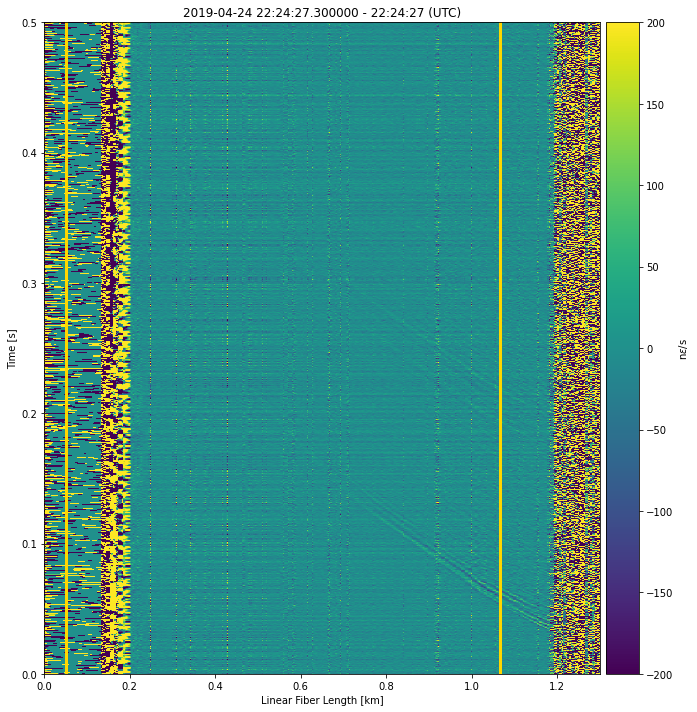

In [19]:
# distances -- move fo_start_in_m to the wellhead position
fo_start_in_m = 50 #m <---- 
fo_end_in_m = fo_start_in_m + fo_distance_in_well
fo_start_in_ch = int(fo_start_in_m/dx_in_m)
fo_end_in_ch = int(fo_end_in_m/dx_in_m)
print('First channel is '+str(fo_start_in_ch))

# interactively plot
fig = utils.image(das,style=1,skip=1,clim=[-200,200])
plt.axvline(fo_start_in_m*dx_in_m/1000,color='gold',lw=3)
plt.axvline(fo_end_in_m*dx_in_m/1000,color='gold',lw=3)
plt.xlim([0,1.3]);

### Basic Plotting

There are 2 plotting methods in the utils package: $\textbf{wiggle}$ and $\textbf{image}$.

In this $\textbf{wiggle}$ method you can play with the following parameters: 
- 'skip' every X ch for speed (=10 by default)
- 'style' plots a simple line (=1 by default) or red/blue plot (=2) 
- 'scale' amplitudes (=1.0 by default) 

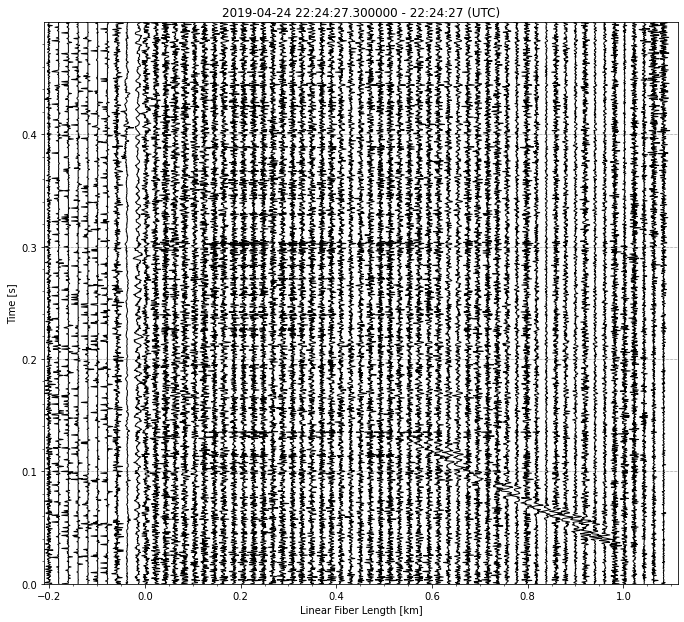

In [20]:
fig = utils.wiggle(das,skip=20)

We can also overlay the geophones and DAS traces

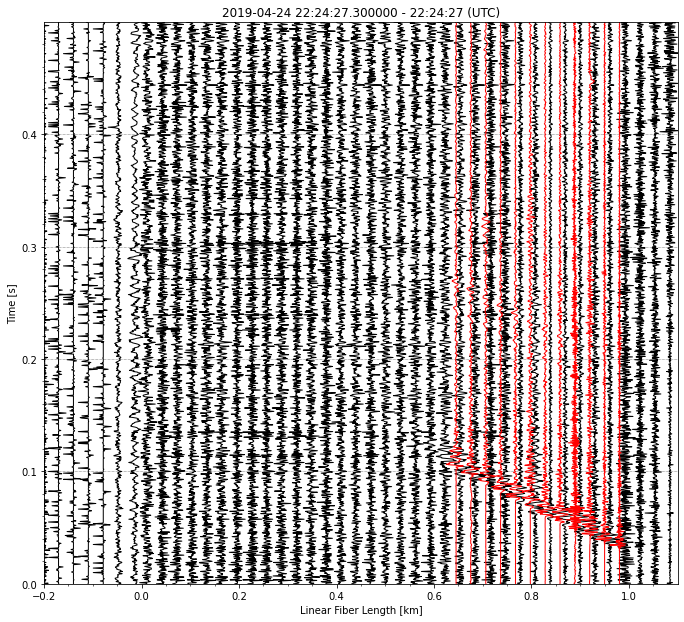

In [21]:
fig = utils.wiggle(das,skip=30,)
fig = utils.wiggle(geo.select(channel='Z'),skip=1,color='r',fig=fig)
plt.xlim([-0.2,1.1]);

In the $\textbf{image}$ method you can play with the following parameters: 
- 'skip' every X ch for speed (=10 by default)
- 'style' modifies the trace normalization, 1 for raw, 2 for trace normalized (=1 by default)
- 'clim' clips the colormap to [min,max] (deactivated =[0] by default) 
- 'physicalFiberLocations' plots the x-axis relative to the wellhead instead of (=False for linear fiber length). Note that the geophone data are located relative to wellhead.

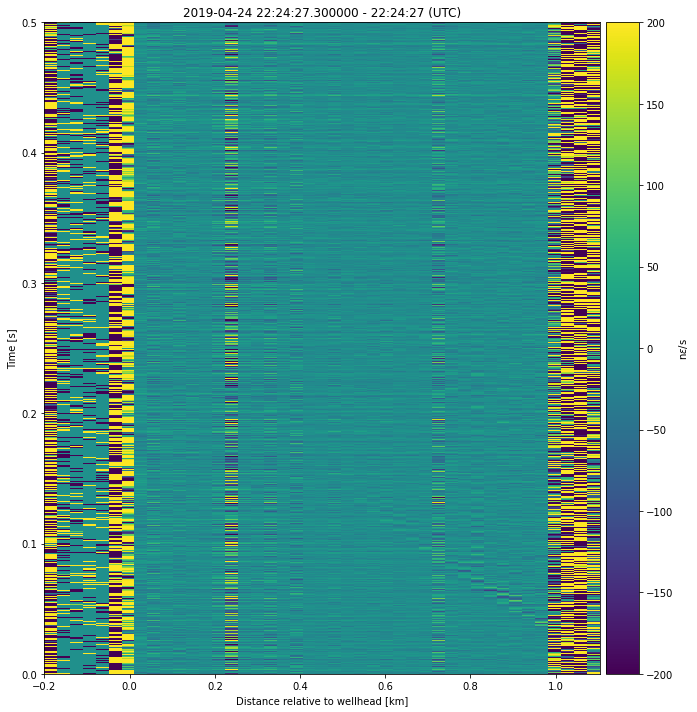

In [22]:
fig = utils.image(das,style=1,skip=30,clim=[-200,200],physicalFiberLocations=True)

Just as in the wiggle case, we can plot geophone wiggle data over an image by sending the fig handle into the wiggle call and then making sure to fix the x-axis limits after.

(-0.2, 1.1)

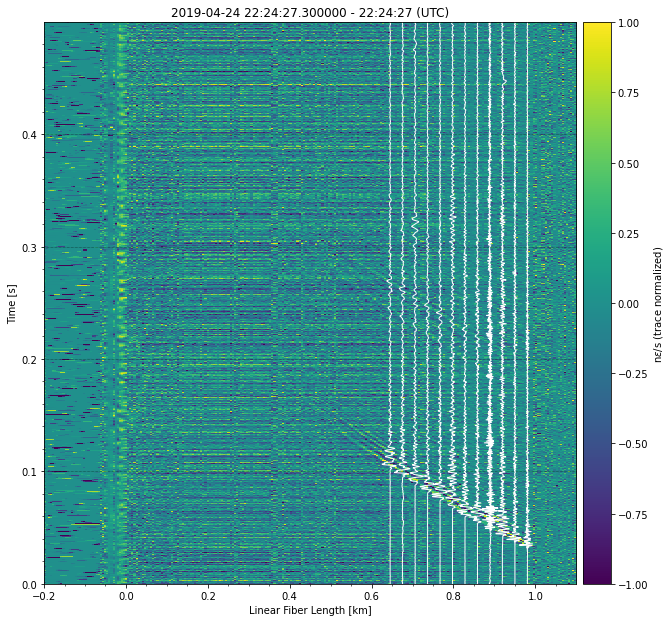

In [23]:
fig = utils.image(das,style=2,skip=5,physicalFiberLocations=True)
fig = utils.wiggle(geo.select(channel='Z'),skip=1,color='w',scale=1.,fig=fig)
plt.xlim([-.2,1.1])

# ! Discuss:

$\textbf{Question}$: Why is QA/QC so important?

$\textbf{Question}$: What are the units of the DAS? What are the units of the geophones?

$\textbf{Question}$: The DAS channel spacing is 1.02 meters, what is the spatial precision?

$\textbf{Question}$: You just began recording DAS with a telecomm cable. How will you establish the physical array geometry? What equipment do you need to bring for the tap test? 

$\textbf{Question}$: When would you use a wiggle plot vs. an image plot?

# 3. Noise Analysis

Load in 30 seconds of continuous, passive recording (no catalogued events documented). This will take about 5 minutes.

In [24]:
time0 = obspy.UTCDateTime(2019,5,2,0,12,0)
time1 = obspy.UTCDateTime(2019,5,2,0,12,30)
das,geo,gaugelength = utils.setup(time0,time1)

FORGE_78-32_iDASv3-P11_UTC190502001153.sgy alrady downloaded!
FORGE_78-32_iDASv3-P11_UTC190502001208.sgy alrady downloaded!
FORGE_78-32_iDASv3-P11_UTC190502001223.sgy alrady downloaded!
20190502001149.236.segy alrady downloaded!
20190502001205.236.segy alrady downloaded!
20190502001221.236.segy alrady downloaded!
Reading forgeData/FORGE_78-32_iDASv3-P11_UTC190502001153.sgy
Reading forgeData/FORGE_78-32_iDASv3-P11_UTC190502001208.sgy
Reading forgeData/FORGE_78-32_iDASv3-P11_UTC190502001223.sgy
Reading forgeData/20190502001149.236.segy
Reading forgeData/20190502001205.236.segy
Reading forgeData/20190502001221.236.segy


### Compute and plot Power Spectral Density

Analyzing the unfiltered power spectral density (PSD) of a DAS array is a good way to begin to understand DAS background noise as a function of frequency and position. 

To compute the PSD of the array, pass the stream object to $\textbf{spectra}$ with the following parameters:
- 'units' allows a choice of 'strain' that will integrate the data (default = 'strain-rate')
- 'kind' chooses amplitude spectra (='as'), power spectra (='ps'), or power spectral density (='psd', default)
- 'trace' if passed, compute for this single trace index only

We can pass the computed spectra (numpy.array) to $\textbf{plotSpectra}$ for plotting. 

If the full array spectra were computed, then we are going to plot an image, or alternatively we can pass just the computed trace spectra for an individual channel spectra line plot. $\textbf{plotSpectra}$ has the following parameters: 
- 'trace' plot for this single trace index only
- 'fig' allows input passing of the figure axis back to overlay traces
- 'units' keeps track of choice of 'strain' or 'strain-rate' for labeling
- 'kind' keeps track of amplitude (='as') or power spectra (='ps'), or PSD (='psd') for labeling
- 'clim' for clipping image colorscale (default is [-70,10])
- 'cmap' for choosing image colorscale map

Compare three trace plots and an image plot of the full array.

/content/forgeUtils.py:273: ComplexWarning: Casting complex values to real discards the imaginary part
  A[i,:] = np.fft.fft(tr.data/1e9)[slice(1,nyq)] # convert from ne/s or ne to e/s or e


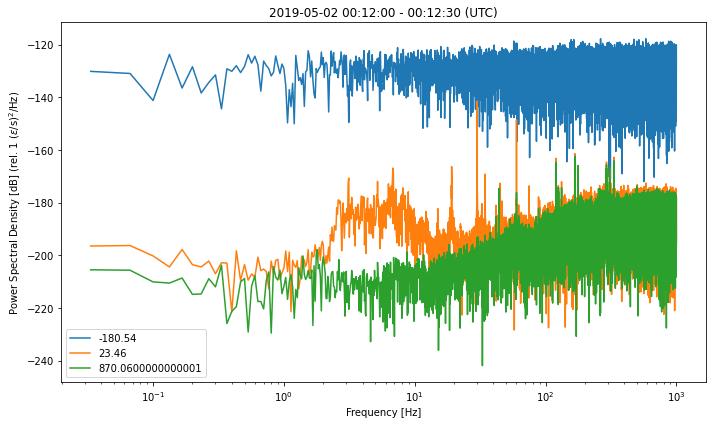

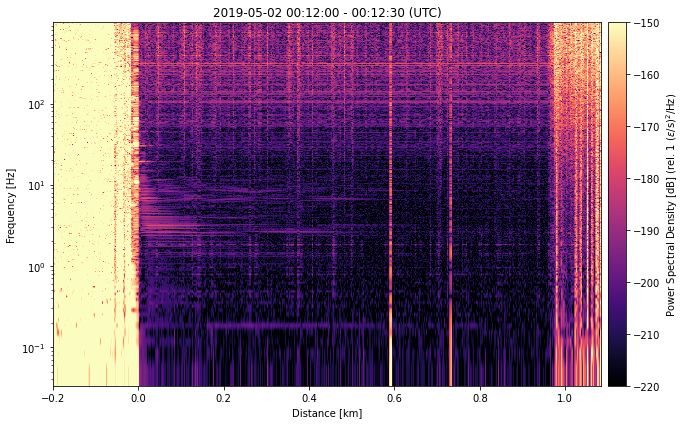

In [25]:
# Plotting traces by index...

tr = 20
fr,psd = utils.spectra(das.copy(),kind='psd',trace=tr) # compute just the trace
fig = utils.plotSpectra(das,fr,psd,clim=[-150,-220],kind='psd',trace=tr)

tr = 220
fr,psd = utils.spectra(das.copy(),kind='psd',trace=tr)
fig = utils.plotSpectra(das,fr,psd,clim=[-150,-220],kind='psd',trace=tr,fig=fig)

tr = 1050
fr,psd = utils.spectra(das.copy(),kind='psd',trace=tr)
fig = utils.plotSpectra(das,fr,psd,clim=[-150,-220],kind='psd',trace=tr,fig=fig)


# Plotting image of full array ...

fr,psd = utils.spectra(das.copy(),kind='psd') # all channels
fig = utils.plotSpectra(das[::20],fr,psd,clim=[-150,-220],kind='psd')

### Plot array noise levels as RMS vs. channel

Using Parseval's theorem, we can measure the RMS noise level in strain-rate or the strain over the array to get a sense of the relative amplitudes. [Current industry standards]('file:///Users/nate/Desktop/Measuring%20Sensor%20Performance.pdf') suggest doing this analysis in strain.

STRAIN-RATE:

/content/forgeUtils.py:273: ComplexWarning: Casting complex values to real discards the imaginary part
  A[i,:] = np.fft.fft(tr.data/1e9)[slice(1,nyq)] # convert from ne/s or ne to e/s or e


(-120.0, -30.0)

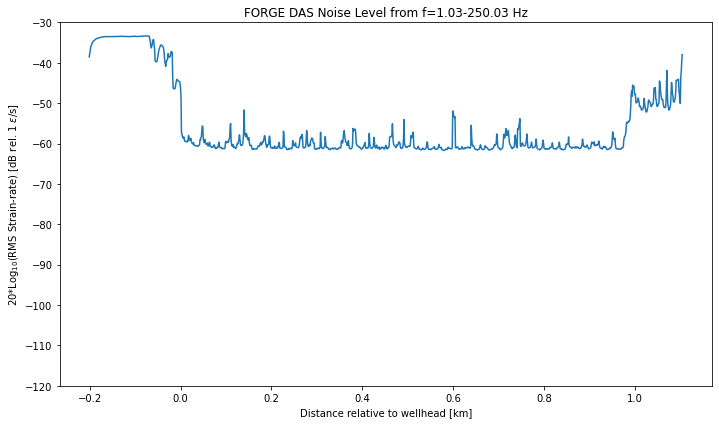

In [26]:
def noise_level(stream,units='strain-rate'):
    
    # compute psd 
    if units=='strain-rate':
        units_plot='20*Log$_{10}$(RMS Strain-rate) [dB rel. 1 $\epsilon$/s]'
        fr,psd_ = utils.spectra(stream.copy(),kind='psd',units='strain-rate') # all channels
    elif units=='strain':
        units_plot='20*Log$_{10}$(RMS Strain) [dB rel. 1 $\epsilon$]'
        fr,psd_ = utils.spectra(stream.copy(),kind='psd',units='strain') # all channels
    
    # compute RMS by integrating PSD (in band around f=1 Hz); and then RMS = sqrt(PSD*df)
    psd_ = np.exp(psd_/10) # convert 10*log10(psd) to raw psd (already rel. to 1 e)
    df =  fr[1]-fr[0] # frequency increment
    f_0 = int(1.0/df) # 1 Hz frequency index
    f_1 = int(250.0/df) # 250 Hz frequency index
    rms_ = np.sqrt(np.sum(psd_[f_0:f_1],axis=0)*df) 

    #plot
    x = np.arange(stream[0].stats.distance,stream[-1].stats.distance,1.02)/1e3 # distances
    plt.figure(figsize=(10,6))
    plt.plot(x,20*np.log10(rms_))
    plt.title('FORGE DAS Noise Level from f=%.2f-%.2f Hz' % (fr[f_0],fr[f_1]))
    plt.xlabel('Distance relative to wellhead [km]')
    plt.ylabel(units_plot)
    plt.tight_layout()
    
#
noise_level(das,units='strain-rate')
plt.ylim([-120,-30])

STRAIN:

/content/forgeUtils.py:273: ComplexWarning: Casting complex values to real discards the imaginary part
  A[i,:] = np.fft.fft(tr.data/1e9)[slice(1,nyq)] # convert from ne/s or ne to e/s or e


(-120.0, -30.0)

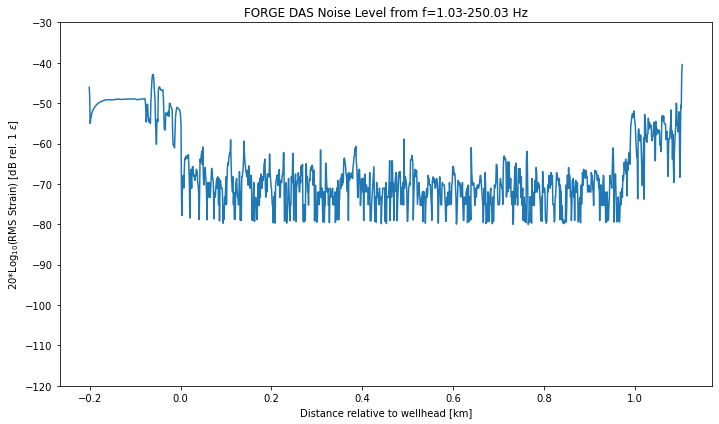

In [27]:
noise_level(das,units='strain')
plt.ylim([-120,-30])

### Plot frequency-wavenumber spectrum

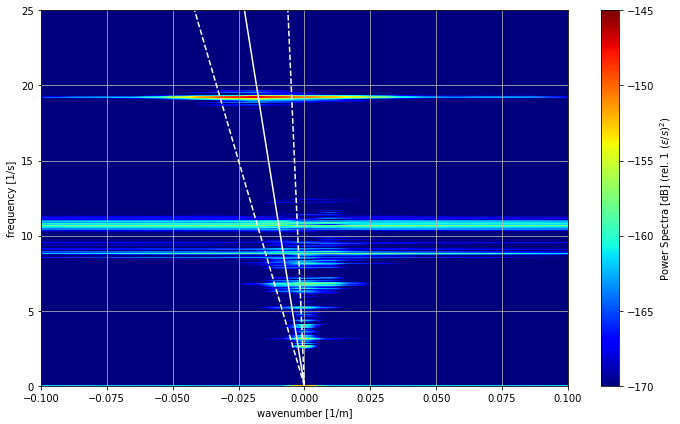

In [28]:
def fk(stream):
    
    import numpy as np
   
    # frequencies
    nt = stream[0].stats.npts
    dt = stream[0].stats.delta
    nyq_f = nt//2
    f = np.fft.fftfreq(nt, d=dt)[slice(0,nyq_f)]
    
    # wavenumbers
    dx = stream[1].stats.distance - stream[0].stats.distance
    nx = len(stream)
    nyq_k = nx//2
    k = np.fft.fftshift(np.fft.fftfreq(nx, d=dx))
    
    # frequency-wavenumber power spectral density
    A = np.fft.fftshift(np.fft.fft2(utils.stream2array(stream)/1e9)[:,slice(0,nyq_f)],axes=0)
    sp2 = 2*(np.abs(A)**2) / (nt**2)
    sp2 = 10*np.log10(sp2)
    
    return f,k,sp2.T

def plotFK(f,k,sp2,vmin=0,vmax=0):
    import numpy as np
    import matplotlib.pyplot as plt
    fig,ax = plt.subplots(figsize=(10,6))
    if vmin==vmax:
        plt.imshow(sp2,extent=[min(k),max(k),min(f),max(f),],
               aspect='auto',cmap='jet',interpolation=None,origin='lower')
    else:
        plt.imshow(sp2,extent=[min(k),max(k),min(f),max(f),],
               aspect='auto',cmap='jet',interpolation=None,origin='lower',
               vmin=vmin,vmax=vmax)
    h = plt.colorbar()
    h.set_label('Power Spectra [dB] (rel. 1 $(\epsilon/s)^2$)')
    plt.ylabel('frequency [1/s]')
    plt.xlabel('wavenumber [1/m]')
    plt.tight_layout()
    return ax

##
f,k,sp2 = fk(das[198:300])
ax = plotFK(f,k,sp2,vmin=-170,vmax=-145)
plt.ylim([0,25])
plt.xlim([-0.1,0.1])
plt.grid()
c=-600; ax.plot(k,k*c,color='w',linestyle='--');
c=-1100; ax.plot(k,k*c,color='w',linestyle='-');
c=-4000; ax.plot(k,k*c,color='w',linestyle='--');

# ! Discuss:

$\textbf{Question}$: Why does the noise increase beyond the end of the well (physical distance > 1 km)?

$\textbf{Question}$: Why do a few channels have anomalously high PSD values inside the well? Hint: Is this seismic or optical noise?

$\textbf{Question}$: What causes the 18 - 20 Hz noise?

$\textbf{Question}$: For the FORGE DAS array, what type of seismic waves would plot in FK-space at positive wavenumber and positive frequency?

# 5. Study an Earthquake 

In [29]:
# Make up a catalog
catalog = {'0' : {'eventName':'perf1','eventTime':obspy.UTCDateTime(2019,4,24,22,24,27.3)},
           '1' : {'eventName':'perf2','eventTime':obspy.UTCDateTime(2019,4,29,16,50,0)}}

In [30]:
# Load one event
time0 = catalog['0']['eventTime']
time1   = time0+0.5
das,geo,gaugelength = utils.setup(time0,time1)

FORGE_78-32_iDASv3-P11_UTC190424222424.sgy alrady downloaded!
20190424222422.196.segy alrady downloaded!
Reading forgeData/FORGE_78-32_iDASv3-P11_UTC190424222424.sgy
Reading forgeData/20190424222422.196.segy


### Filter DAS and geophone records for earthquake and visually interpret

### --> Add median subtraction filtering

(-0.2, 0.2)

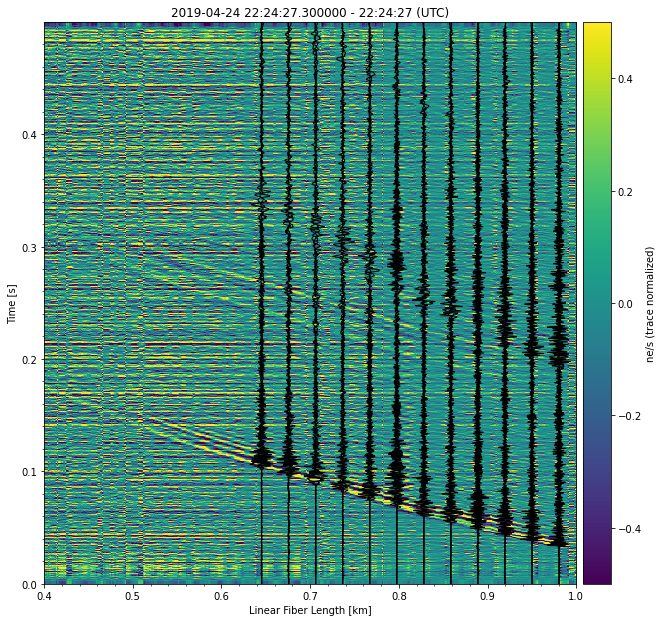

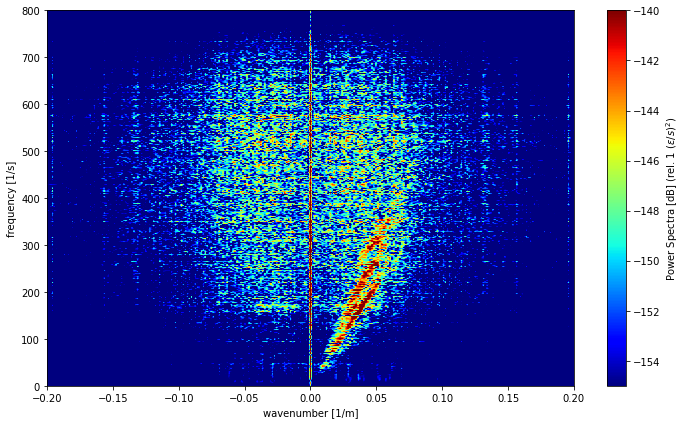

In [31]:
#filtering
fmin=10
fmax=700
das_ = das.copy().detrend().taper(0.02).filter('bandpass',freqmin=fmin,freqmax=fmax,zerophase=True,corners=2)
geo_ = geo.copy().detrend().taper(0.02).filter('bandpass',freqmin=fmin,freqmax=fmax,zerophase=True,corners=2)

# TX
fig = utils.image(das_,style=2,skip=1,physicalFiberLocations=True,clim=[-0.5,0.5])
fig = utils.wiggle(geo_,style=1,skip=1,scale=2,fig=fig)
plt.axvline(780,color='brown',linestyle='--')
plt.xlim([0.4,1.])

# FK
f,k,sp2 = fk(das_[500:1150])
ax = plotFK(f,k,sp2,vmin=-155,vmax=-140)
plt.ylim([0,800])
plt.xlim([-0.2,0.2])
# c=-4000; ax.plot(k,k*c,color='w');

### Compare Geophones and DAS

Colocated simultaneous recordings made by inertial geophones and DAS can be compared directly after basic processing. The processing steps required for this instrument comparison involve spatial or temporal derivatives. 

Consider the propagating displacement wavefield in space $x$ and time $t$ with amplitude $A$, 

$$
U(x,t) = Ae^{i(\omega t-kx)}.
$$

$k$ is the spatial frequency ($k=2\pi /$wavelength). $\omega$ is the temporal frequency ($\omega=2\pi$* frequency). These quantities are related through the wave's phase velocity, $c=\omega/k$.

Common open-loop geophones will record the particle velocity of $U$, which is mathematically equivalent to taking one time-derivative of the displacement:

$$
\frac{dU(x,t)}{dt} = i\omega Ae^{i(\omega t\pm kx)}
$$

The DAS instrument records the strain-rate field, equivalent to taking one space-derivative and one time-derivative of the displacement:

$$
\frac{d\epsilon(x,t)}{dt} = \frac{d}{dt}(\frac{dU(x,t)}{dx}) = -\omega k Ae^{i(\omega t\pm kx)}.
$$

The amplitude and phase of geophone and DAS data can thus be compared in absolute units of strain by multiplying the geophone data by the inverse phase velocity ($\frac{1}{c}$, a multiplicative constant under the acoustic plane wave assumption) and integrating the DAS data:
$$
\epsilon(x,t) = \frac{\omega}{k}\frac{dU(x,t)}{dt} = \frac{1}{c}\frac{dU(x,t)}{dt}.
$$

Alternatively, we can differentiate the geophone data to acceleration and multiply the DAS data by inverse phase velocity:
$$
\frac{d^2U(x,t)}{dt^2} = -\omega^2 Ae^{i(\omega t\pm kx)}
$$
$$
\frac{d\epsilon(x,t)}{dt} = \frac{\omega}{k}\frac{d}{dt}(\frac{d^2U(x,t)}{dt^2}) = \frac{1}{c}\frac{d^2U(x,t)}{dt^2}
$$

If the phase velocity is unknown, any comparison will only result in a relative amplitude scale (but records should be in-phase).

We process the geophone point sensor data by loading the raw velocity data, applying a linear detrend, mean removal, and 2% taper, then differentiating to acceleration data, and finally applying a two-corner, causal bandpass filter in the range 1 - 1000 Hz. 

We process the DAS array data by applying a linear detrend, mean removal, and 2% taper, then removing the zero-wavenumber noise in the frequency-wavenumber domain over the full array of sensors installed in the well, and finally applying a two-corner, causal bandpass filter in the range 1 - 1000 Hz. 

# ! Discuss

$\textbf{Question}$: Describe the wave propagation for stimulation microearthquakes to the surface along the well path.

$\textbf{Question}$: Estimate the P-wave and S-wave speed profile for the well? Describe all assumptions.

$\textbf{Question}$: What causes the zero wavenumber noise? Describe how you could remove this noise.

$\textbf{Question}$: If you wanted to detect more earthquakes using DAS, how could you go about using the array to do this?